<a href="https://colab.research.google.com/github/caluq/elec4630/blob/main/src/mittens_and_fido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ELEC4630 Exercise on Face Recognition
First check if the dlib library is installed

In [ ]:
!pip install dlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Get some sample images from gitHub and place them a folder called 'images'.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# First store some sample images in the folder 'images'
!mkdir -p images
!cd images; wget -nc https://github.com/caluq/elec4630/blob/f713b7e2d0656f8f3a6dd1dac1c4792077b523d4/images/image_0001.jpg
#!cd images; wget -nc https://raw.githubusercontent.com/lovellbrian/ELEC4630/master/Images/biden.jpg
!cd images; wget -nc https://github.com/caluq/elec4630/blob/5559fccf201435ab6984eb50837d30117ba83676/images/image_0002.jpg

--2022-06-01 10:16:39--  https://github.com/caluq/elec4630/blob/f713b7e2d0656f8f3a6dd1dac1c4792077b523d4/images/image_0001.jpg
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘image_0001.jpg’

image_0001.jpg          [ <=>                ] 124.31K  --.-KB/s    in 0.04s   

2022-06-01 10:16:39 (3.21 MB/s) - ‘image_0001.jpg’ saved [127289]

--2022-06-01 10:16:39--  https://github.com/caluq/elec4630/blob/5559fccf201435ab6984eb50837d30117ba83676/images/image_0002.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘image_0002.jpg’

image_0002.jpg          [ <=>                ] 124.31K  --.-KB/s    in 0.04s   

2022-06-01 10:16:40 (3.36 MB/s) - ‘image_0002.jpg’ saved [127

Now install the face recognition module from Dlib

In [ ]:
!pip3 install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100.1 MB 27 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=e0729a1993f01a1658d57a89e24a03d28634f530b6d7dd77767a3708485cb00c
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


Now lets find some faces!

In [ ]:
import face_recognition
from PIL import Image, ImageDraw
import numpy as np

# This is an example of running face recognition on a single image
# and drawing a box around each person that was identified.

# Load a sample picture and learn how to recognize it.
prefix = "/content/drive/MyDrive/ELEC4630/ass3/Image_0001_faces/" 
image_list = os.listdir(prefix)
image_list.sort() 

image_0001 = face_recognition.load_image_file(prefix + image_list[1])
image_0001_face_encoding = face_recognition.face_encodings(image_0001)[0]

# Load a second sample picture and learn how to recognize it.
#biden_image = face_recognition.load_image_file("images/biden.jpg")
#biden_face_encoding = face_recognition.face_encodings(biden_image)[0]

# Create arrays of known face encodings and their names
known_face_encodings = [
    image_0001_face_encoding
]
known_face_names = [
    "image_0001"
]

positive_images = [None] * len(image_list)
tolerance_quantity = 18
tolerances = np.linspace(0.05, 0.95, tolerance_quantity)

true_positives = [0] * tolerance_quantity
false_negatives = [0] * tolerance_quantity
true_negatives = [0] * tolerance_quantity
false_positives = [0] * tolerance_quantity

positive_image_quantity = len(image_list)

for i in range(2, positive_image_quantity):
    tol = tolerances[t]
    positive_images[i] = face_recognition.load_image_file(prefix + image_list[i])
    unknown_image = positive_images[i]

    # Find all the faces and face encodings in the unknown image
    face_locations = face_recognition.face_locations(unknown_image)
    face_encodings = face_recognition.face_encodings(unknown_image, face_locations)

    # Convert the image to a PIL-format image so that we can draw on top of it with the Pillow library
    # See http://pillow.readthedocs.io/ for more about PIL/Pillow
    pil_image = Image.fromarray(unknown_image)
    # Create a Pillow ImageDraw Draw instance to draw with
    draw = ImageDraw.Draw(pil_image)

    # Loop through each face found in the unknown image
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings, ):
        for t in range(0, tolerance_quantity):

            tol = tolerances[t]
            matches = []
            # See if the face is a match for the known face(s)
            matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=tol)
            name = "Unknown"

            # If a match was found in known_face_encodings, just use the first one.
            # if True in matches:
            #     first_match_index = matches.index(True)
            #     name = known_face_names[first_match_index]

            # Or instead, use the known face with the smallest distance to the new face
            face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
            best_match_index = np.argmin(face_distances)

            if matches[best_match_index]:
                name = known_face_names[best_match_index]
                true_positives[t] = true_positives[t] + 1
            else:
                false_negatives[t] = false_negatives[t] + 1

#################### Negative images #####################
# Load a sample picture and learn how to recognize it.
prefix = "/content/drive/MyDrive/ELEC4630/ass3/Other_faces/" 
image_list = os.listdir(prefix)
image_list.sort() 

negative_images = [None] * len(image_list)
negative_image_quantity = len(image_list)

for i in range(1, negative_image_quantity):
    negative_images[i] = face_recognition.load_image_file(prefix + image_list[i])
    unknown_image = negative_images[i]

    # Find all the faces and face encodings in the unknown image
    face_locations = face_recognition.face_locations(unknown_image)
    face_encodings = face_recognition.face_encodings(unknown_image, face_locations)

    # Convert the image to a PIL-format image so that we can draw on top of it with the Pillow library
    # See http://pillow.readthedocs.io/ for more about PIL/Pillow
    pil_image = Image.fromarray(unknown_image)
    # Create a Pillow ImageDraw Draw instance to draw with
    draw = ImageDraw.Draw(pil_image)

    # Loop through each face found in the unknown image
    for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
          for t in range(0, tolerance_quantity):

              tol = tolerances[t]
              matches = []
              # See if the face is a match for the known face(s)
              matches = face_recognition.compare_faces(known_face_encodings, face_encoding, tolerance=tol)
              name = "Unknown"

              # If a match was found in known_face_encodings, just use the first one.
              # if True in matches:
              #     first_match_index = matches.index(True)
              #     name = known_face_names[first_match_index]

              # Or instead, use the known face with the smallest distance to the new face
              face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
              best_match_index = np.argmin(face_distances)

              if matches[best_match_index]:
                  name = known_face_names[best_match_index]
                  false_positives[t] = false_positives[t] + 1
              else:
                  true_negatives[t] = true_negatives[t] + 1



'true positive_rate : '

[0.0,
 0.0,
 0.47368421052631576,
 0.631578947368421,
 0.7368421052631579,
 0.8421052631578947,
 0.8947368421052632,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

'false positive_rate : '

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0022935779816513763,
 0.0022935779816513763,
 0.04357798165137615,
 0.1926605504587156,
 0.5527522935779816,
 0.8027522935779816,
 0.9885321100917431,
 1.0]

'threshold delta : '

0.05294117647058823

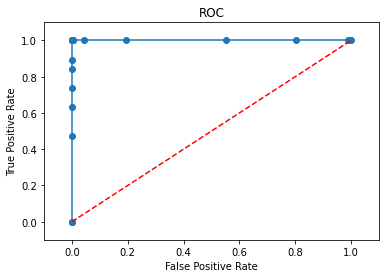

In [ ]:
import matplotlib.pyplot as plt
true_positives_rate = [0] * tolerance_quantity
false_positives_rate = [0] * tolerance_quantity

for t in range(0, tolerance_quantity):   
    true_positives_rate[t] = true_positives[t] / (true_positives[t] + false_negatives[t])
    false_positives_rate[t] = false_positives[t] / (false_positives[t] + true_negatives[t])

display("true positive_rate : ")
display(true_positives_rate)
display("false positive_rate : ")
display(false_positives_rate)
display("threshold delta : ")
display(tolerances[1] - tolerances[0])

plt.title('ROC') 
plt.plot(false_positives_rate, true_positives_rate, '-o', label = 'AUC = %0.2f')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()